Function takes a dict of patient dataframes
Create Sliding Window feature vectors or some many of feature vectors
Add Engineered features

RunLGBM

Eval outputs

Grid Search - Machine Learning library to run 10k combos with json input

In [1]:
import os
from pprint import pprint
import pandas as pd

import lgbm_pipeline.feature_load as loader

patients: list[pd.DataFrame] = loader.load_training_data(f"{os.getcwd()}/training_setB/*.psv")

Loading PSV Files: 100%|██████████| 20000/20000 [00:33<00:00, 592.98it/s]


In [2]:
import lgbm_pipeline.feature_extraction as extractor
patients_forward = extractor.fill(patients, extractor.FillMethod.FORWARD)
patients_backwards = extractor.fill(patients, extractor.FillMethod.BACKWARD)
patients_linear = extractor.fill(patients, extractor.FillMethod.LINEAR)

<Axes: >

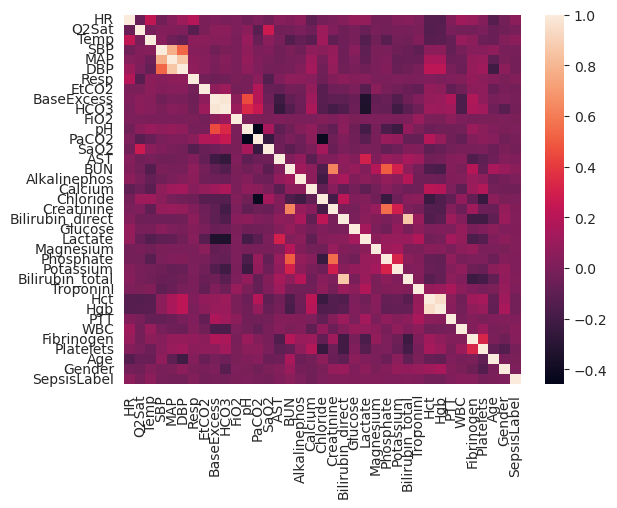

In [13]:
import seaborn as sns
sns.heatmap(pd.concat(patients_forward).corr(), xticklabels=True, yticklabels=True)

<Axes: >

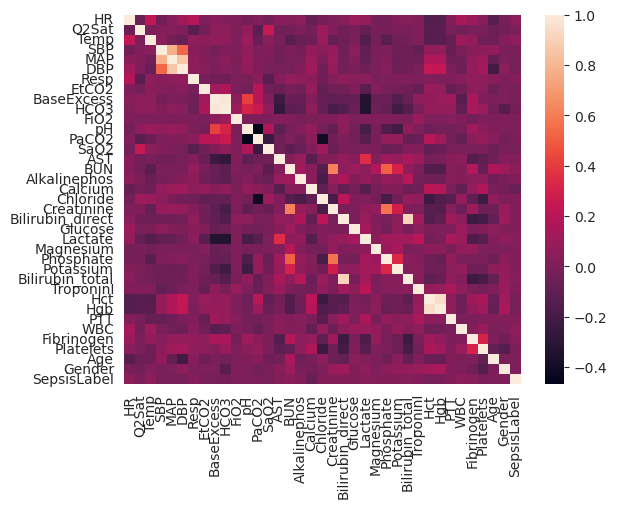

In [14]:
sns.heatmap(pd.concat(patients_backwards).corr(), xticklabels=True, yticklabels=True)

<Axes: >

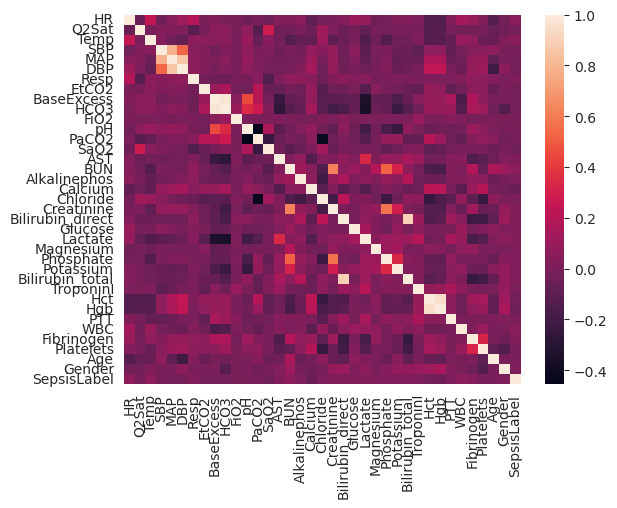

In [15]:
sns.heatmap(pd.concat(patients_linear).corr(), xticklabels=True, yticklabels=True)

In [ ]:
patients_with_fill_methods: dict[extractor.FillMethod, list[pd.DataFrame]] = {extractor.FillMethod.FORWARD: patients_forward,
                              extractor.FillMethod.BACKWARD: patients_backwards,
							  extractor.FillMethod.LINEAR: patients_linear}
all_patients_mixed = extractor.mixed_fill(patients_with_fill_methods)

{'HR': <FillMethod.BACKWARD: 2>, 'O2Sat': <FillMethod.LINEAR: 3>, 'Temp': <FillMethod.BACKWARD: 2>, 'SBP': <FillMethod.LINEAR: 3>, 'MAP': <FillMethod.LINEAR: 3>, 'DBP': <FillMethod.LINEAR: 3>, 'Resp': <FillMethod.FORWARD: 1>, 'EtCO2': <FillMethod.LINEAR: 3>, 'BaseExcess': <FillMethod.LINEAR: 3>, 'HCO3': <FillMethod.LINEAR: 3>, 'FiO2': <FillMethod.BACKWARD: 2>, 'pH': <FillMethod.FORWARD: 1>, 'PaCO2': <FillMethod.LINEAR: 3>, 'SaO2': <FillMethod.LINEAR: 3>, 'AST': <FillMethod.BACKWARD: 2>, 'BUN': <FillMethod.BACKWARD: 2>, 'Alkalinephos': <FillMethod.BACKWARD: 2>, 'Calcium': <FillMethod.LINEAR: 3>, 'Chloride': <FillMethod.BACKWARD: 2>, 'Creatinine': <FillMethod.BACKWARD: 2>, 'Bilirubin_direct': <FillMethod.LINEAR: 3>, 'Glucose': <FillMethod.LINEAR: 3>, 'Lactate': <FillMethod.BACKWARD: 2>, 'Magnesium': <FillMethod.FORWARD: 1>, 'Phosphate': <FillMethod.BACKWARD: 2>, 'Potassium': <FillMethod.BACKWARD: 2>, 'Bilirubin_total': <FillMethod.LINEAR: 3>, 'TroponinI': <FillMethod.BACKWARD: 2>, 'Hct':

: 

In [9]:
pprint(pd.concat(patients_linear).corr()["SepsisLabel"])

HR                  0.051985
O2Sat              -0.012575
Temp                0.055195
SBP                -0.016336
MAP                -0.021895
DBP                -0.022439
Resp                0.021214
EtCO2              -0.020067
BaseExcess         -0.019717
HCO3               -0.026760
FiO2                0.000533
pH                  0.002732
PaCO2              -0.012562
SaO2               -0.030858
AST                 0.015829
BUN                 0.051054
Alkalinephos        0.008941
Calcium            -0.062267
Chloride            0.007150
Creatinine          0.018743
Bilirubin_direct    0.022035
Glucose             0.017399
Lactate             0.027072
Magnesium           0.021542
Phosphate           0.016852
Potassium           0.014744
Bilirubin_total     0.025409
TroponinI           0.010137
Hct                -0.027483
Hgb                -0.029144
PTT                 0.009744
WBC                 0.047518
Fibrinogen          0.030396
Platelets          -0.016035
Age           

In [ ]:
# create sliding window of feature vectors
windows = []
for key, val in patients.items():
	val.index = pd.to_timedelta(val.index, 'h')
	windows.append(val.rolling("6h").mean())

In [ ]:
pprint(windows[0:10])

In [ ]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X = []
y = []
for patient in windows:
	X.append(patient.drop("SepsisLabel", axis="columns", inplace=False))
	y.append(patient["SepsisLabel"])

X_train, X_val, y_train, y_val = train_test_split(X, y)
classifier = lgbm.LGBMClassifier()
classifier.fit(X_train, y_train)